In [1]:
import torch
import numpy as np
from scipy.spatial import SphericalVoronoi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm

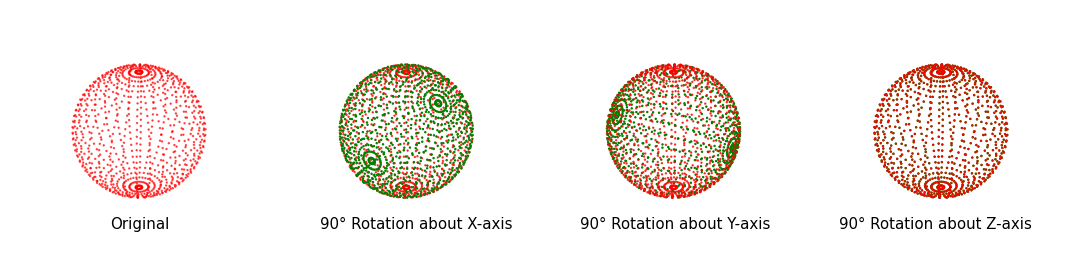

In [ ]:
def spherical_grid_3d(n_angle):
    # Voronoi Regions
    j = torch.arange(n_angle)
    theta, phi = torch.meshgrid(torch.pi * (j + 0.5) / n_angle, 2*torch.pi*(j+0.5) / n_angle, indexing='ij')
    x = (torch.sin(theta) * torch.cos(phi)).flatten()
    y = (torch.sin(theta) * torch.sin(phi)).flatten()
    z = torch.cos(theta).flatten()
    return torch.vstack([x, y, z])

def rotate_points(points, axis='x', angle_deg=90):
    angle_rad = np.radians(angle_deg)
    if axis == 'x':
        R = torch.tensor([[1, 0, 0],
                      [0, np.cos(angle_rad), -np.sin(angle_rad)],
                      [0, np.sin(angle_rad),  np.cos(angle_rad)]])
    elif axis == 'y':
        R = torch.tensor([[ np.cos(angle_rad), 0, np.sin(angle_rad)],
                      [0, 1, 0],
                      [-np.sin(angle_rad), 0, np.cos(angle_rad)]])
    elif axis == 'z':
        R = torch.tensor([[np.cos(angle_rad), -np.sin(angle_rad), 0],
                      [np.sin(angle_rad),  np.cos(angle_rad), 0],
                      [0, 0, 1]])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")
    return R.type(torch.float) @ points

def plot_rotated_vs_original(n_angle):
    points = spherical_grid_3d(n_angle)
    fig, axes = plt.subplots(nrows=1, ncols=4, subplot_kw={"projection": "3d"}, gridspec_kw={'hspace':0})
    fig.set_size_inches(15,4)
    
    for ax in axes:
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_zlim([-1.1, 1.1])
        ax.set_box_aspect([1, 1, 1])
        ax.axis('off')

    # Plot original DH grid
    axes[0].scatter(points[0], points[1], points[2],
                color='red', s=2, alpha=0.6, label='Original')
    fig.text(0.105,0.175,s=f'Original', fontsize=15)

    for i, rotation_axis in enumerate(['x', 'y', 'z']):
        rotated = rotate_points(points, axis=rotation_axis, angle_deg=90)

        # Plot original DH grid
        axes[i+1].scatter(points[0], points[1], points[2],
                   color='red', s=2, alpha=0.7, label='Original')

        # Plot rotated grid
        axes[i+1].scatter(rotated[0], rotated[1], rotated[2],
                   color='green', s=2, alpha=1, label=f'Rotated about {rotation_axis.upper()}')

        fig.text(0.24*i + 0.3,0.175,s=f'90° Rotation about {rotation_axis.upper()}-axis', fontsize=15)
        
    plt.tight_layout()
    plt.show()

# Main
plot_rotated_vs_original(32)

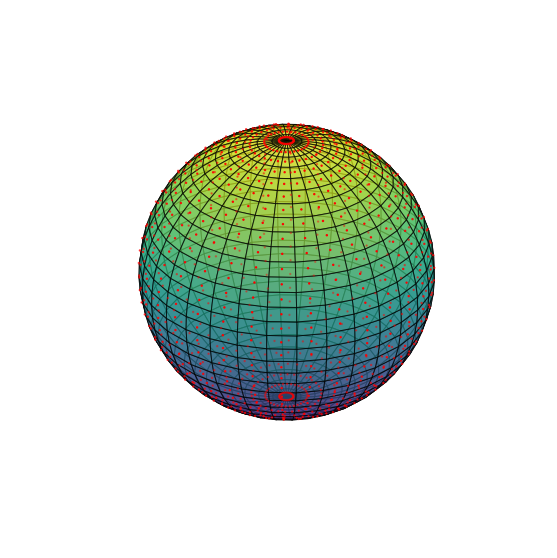

In [3]:
def plot_gradient_voronoi(n_angle):
    points = spherical_grid_3d(n_angle)
    sv = SphericalVoronoi(points.T)
    sv.sort_vertices_of_regions()
    
    # Plot Settings
    norm = plt.Normalize(vmin=-1, vmax=1)
    cmap = cm.viridis
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    
    # Plotting
    for i, region in enumerate(sv.regions):
        color = cmap(norm(points[2][i]))
        poly = Poly3DCollection([sv.vertices[region]], alpha=0.7)
        poly.set_facecolor(color)
        poly.set_edgecolor('k')
        poly.set_linewidth(1)
        ax.add_collection3d(poly)
    
    ax.scatter(points[0], points[1], points[2], s=2, color='red')
    ax.set_box_aspect([1, 1, 1])
    ax.set_xlim([-1.05, 1.05])
    ax.set_ylim([-1.05, 1.05])
    ax.set_zlim([-1.05, 1.05])
    plt.axis('off')
    plt.show()


plot_gradient_voronoi(n_angle=32)


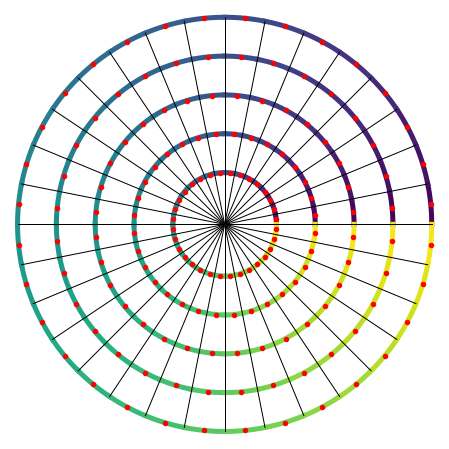

In [ ]:
def plot_voronoi_with_arc_midpoints(n_angle):
    radii = np.linspace(0.25, 1.0, 5)
    delta_phi = 2 * np.pi / n_angle
    boundary_angles = np.linspace(0, 2 * np.pi, n_angle, endpoint=False)
    phi_centres = boundary_angles + delta_phi / 2

    cmap = cm.viridis
    norm = plt.Normalize(vmin=0, vmax=2 * np.pi)

    fig, ax = plt.subplots(figsize=(8, 8))

    # Draw coloured arcs
    for r in radii:
        for phi_c in phi_centres:
            arc_phis = np.linspace(phi_c - delta_phi / 2,
                                   phi_c + delta_phi / 2,
                                   60)
            ax.plot(r * np.cos(arc_phis),
                    r * np.sin(arc_phis),
                    lw=5,
                    color=cmap(norm(phi_c)))

            # midpoint of this arc (on the circle, at phi_c)
            ax.scatter(r * np.cos(phi_c),
                       r * np.sin(phi_c),
                       s=20, color='red', marker='o', zorder=3)

    # Draw radial boundaries
    for phi in boundary_angles:
        ax.plot([0, radii[-1] * np.cos(phi)],
                [0, radii[-1] * np.sin(phi)],
                color='black', lw=1)

    # Formatting
    ax.set_aspect('equal')
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim(-1.05, 1.05)
    ax.axis('off')
    plt.show()

# Preview
plot_voronoi_with_arc_midpoints(32)